# Machine Learning with Spark

In this lesson we'll take a look at how to implement and evaluate machine learning models with spark.

## Setup

First we'll do a couple of imports and setup our spark session.

In [1]:
%matplotlib inline
from pydataset import data

import pyspark
import pyspark.ml
from pyspark.sql.functions import *

spark = pyspark.sql.SparkSession.builder.getOrCreate()

The data we'll use for this lesson is the `swiss` dataset. We'll cleanup the column names just a bit before we turn the dataset into a spark dataframe.

In [2]:
swiss = data("swiss")
swiss.columns = [col.lower().replace(".", "_") for col in swiss]
swiss = spark.createDataFrame(swiss)
swiss.show(5)

+---------+-----------+-----------+---------+--------+----------------+
|fertility|agriculture|examination|education|catholic|infant_mortality|
+---------+-----------+-----------+---------+--------+----------------+
|     80.2|       17.0|         15|       12|    9.96|            22.2|
|     83.1|       45.1|          6|        9|   84.84|            22.2|
|     92.5|       39.7|          5|        5|    93.4|            20.2|
|     85.8|       36.5|         12|        7|   33.77|            20.3|
|     76.9|       43.5|         17|       15|    5.16|            20.6|
+---------+-----------+-----------+---------+--------+----------------+
only showing top 5 rows



## Classification

We'll first take a look at implementing a classification model. In order to do so, we'll need a categorical variable to predict. We'll transform the `catholic` column into a categorical variable indicating whether a province is catholic or not.

First we'll plot a histogram to justify why this transformation is reasonable to make:  


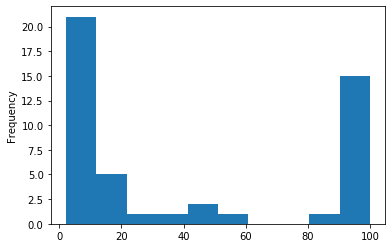

In [3]:
swiss.toPandas().catholic.plot.hist()

The visualization above tells us that most provinces fall into on of two extremes in regards to percentage catholic.

We'll now go ahead and use spark to make the transformation.


In [4]:
swiss = swiss.withColumn(
    "is_catholic",
    when(swiss.catholic > 60, "Catholic").otherwise("Not Catholic"),
).drop("catholic")
swiss.show(5)

+---------+-----------+-----------+---------+----------------+------------+
|fertility|agriculture|examination|education|infant_mortality| is_catholic|
+---------+-----------+-----------+---------+----------------+------------+
|     80.2|       17.0|         15|       12|            22.2|Not Catholic|
|     83.1|       45.1|          6|        9|            22.2|    Catholic|
|     92.5|       39.7|          5|        5|            20.2|    Catholic|
|     85.8|       36.5|         12|        7|            20.3|Not Catholic|
|     76.9|       43.5|         17|       15|            20.6|Not Catholic|
+---------+-----------+-----------+---------+----------------+------------+
only showing top 5 rows



### Reshaping Our Data For Machine Learning

Spark's machine learning library requires that our data be in a very specific format. A dataframe that will be used with one of spark's machine learning models must have one column (`features`) that contains a list of the independent variable values, and another column (`label`) that contains the target variable. In addition, all numbers must be floats. Luckily, spark supplies us with some functionality to make this transformation pretty easy.

Within the `pyspark.ml.feature` module are many classes that perform different transformations on dataframes, for example, min-max scaling. We'll take a look at the `RFormula` class, which we can use to quickly transform our data into the necessary format.

!!!note "Other Transformations With Spark"
    We are just exploring the `RFormula` class in this lesson, but the `pyspark.ml.feature` module contains many more classess as well, for things like scaling numeric features, or extracting tokens from text.

The way we work with this class is similar to how we work with the `sklearn` classes, in that we'll first need to fit the object, then transform.

In [5]:
from pyspark.ml.feature import RFormula

rf = RFormula(formula="is_catholic ~ agriculture + examination")

df = rf.fit(swiss).transform(swiss)

Here we specified a string containing a formula that describes a linear model to be fit. This formula is taken from the R programming langauge. Here are several examples:

- `y ~ x`: predict `y` based on `x`
- `y ~ x1 + x2 + x3`: predict `y` based on `x1`, `x2`, and `x3`
- `y ~ .`: predict `y` based on all of the variables except for the independent variable (i.e. everything except for `y`)

In our case, we wrote a formula to predict `is_catholic` based on `agriculture` and `examination`.

The `RFormula` object will add two new columns to our data frame, `features`, and `label`, and we'll store those in `df` so that we can feed them into a Logistic Regression model.


In [6]:
df.show(5)

+---------+-----------+-----------+---------+----------------+------------+-----------+-----+
|fertility|agriculture|examination|education|infant_mortality| is_catholic|   features|label|
+---------+-----------+-----------+---------+----------------+------------+-----------+-----+
|     80.2|       17.0|         15|       12|            22.2|Not Catholic|[17.0,15.0]|  0.0|
|     83.1|       45.1|          6|        9|            22.2|    Catholic| [45.1,6.0]|  1.0|
|     92.5|       39.7|          5|        5|            20.2|    Catholic| [39.7,5.0]|  1.0|
|     85.8|       36.5|         12|        7|            20.3|Not Catholic|[36.5,12.0]|  0.0|
|     76.9|       43.5|         17|       15|            20.6|Not Catholic|[43.5,17.0]|  0.0|
+---------+-----------+-----------+---------+----------------+------------+-----------+-----+
only showing top 5 rows



In [7]:
from pyspark.ml.classification import LogisticRegression

Once we've imported the `LogisticRegression` class, we can make an instance of it, and use the `.fit` method to get a fitted model.


In [8]:
lr = LogisticRegression()
# lr.explainParams() # to show all of the hyperparams
lr_fit = lr.fit(df)
lr_fit

LogisticRegressionModel: uid = LogisticRegression_1bc73b0acb59, numClasses = 2, numFeatures = 2

The `.transform` method can be used to make predictions with our model. The data we give to the `.transform` method needs to be in the same shape that we used for training the model.

We'll also add a column named `we_got_it_right`, which is boolean value that indicates whether or not our prediction was correct.

In [9]:
(
    lr_fit.transform(df)
    .withColumn("we_got_it_right", col("label") == col("prediction"))
    .select(
        "is_catholic",
        "label",
        "rawPrediction",
        "probability",
        "prediction",
        "we_got_it_right",
    )
).show(5)

+------------+-----+--------------------+--------------------+----------+---------------+
| is_catholic|label|       rawPrediction|         probability|prediction|we_got_it_right|
+------------+-----+--------------------+--------------------+----------+---------------+
|Not Catholic|  0.0|[2.61081360006245...|[0.93155429036120...|       0.0|           true|
|    Catholic|  1.0|[-1.9844861732885...|[0.12084142107894...|       1.0|           true|
|    Catholic|  1.0|[-2.1417946363626...|[0.10510047647313...|       1.0|           true|
|Not Catholic|  0.0|[0.65897957038476...|[0.65903112585454...|       0.0|           true|
|Not Catholic|  0.0|[2.27460235659845...|[0.90675166037879...|       0.0|           true|
+------------+-----+--------------------+--------------------+----------+---------------+
only showing top 5 rows



To evaluate our model's performance, we can take a look at the `summary` property of the fit model.


In [10]:
training_summary = lr_fit.summary
training_summary

This summary contains many properties that are common classification metrics. Several examples are shown below:

In [11]:
training_summary.areaUnderROC

0.9314516129032258

In [12]:
training_summary.accuracy

0.8723404255319149

In [13]:
training_summary.recallByLabel

[0.9354838709677419, 0.75]

In [14]:
training_summary.precisionByLabel

[0.8787878787878788, 0.8571428571428571]

## Regression

Building a regression model will follow the same pattern as building the classification model.

For this example, we'll try to predict `fertility` based on `education` and `examination`.

In [15]:
swiss.show()

+---------+-----------+-----------+---------+----------------+------------+
|fertility|agriculture|examination|education|infant_mortality| is_catholic|
+---------+-----------+-----------+---------+----------------+------------+
|     80.2|       17.0|         15|       12|            22.2|Not Catholic|
|     83.1|       45.1|          6|        9|            22.2|    Catholic|
|     92.5|       39.7|          5|        5|            20.2|    Catholic|
|     85.8|       36.5|         12|        7|            20.3|Not Catholic|
|     76.9|       43.5|         17|       15|            20.6|Not Catholic|
|     76.1|       35.3|          9|        7|            26.6|    Catholic|
|     83.8|       70.2|         16|        7|            23.6|    Catholic|
|     92.4|       67.8|         14|        8|            24.9|    Catholic|
|     82.4|       53.3|         12|        7|            21.0|    Catholic|
|     82.9|       45.2|         16|       13|            24.4|    Catholic|
|     87.1| 

Like before, we'll use the `RFormula` object to transform our data:


In [16]:
rf = RFormula(formula="fertility ~ education + examination")

df = rf.fit(swiss).transform(swiss).select("features", "label")

df.show(5)

+-----------+-----+
|   features|label|
+-----------+-----+
|[12.0,15.0]| 80.2|
|  [9.0,6.0]| 83.1|
|  [5.0,5.0]| 92.5|
| [7.0,12.0]| 85.8|
|[15.0,17.0]| 76.9|
+-----------+-----+
only showing top 5 rows



And then feed the data into a spark machine learning model:


In [17]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression()
lr_fit = lr.fit(df)
lr_fit.transform(df).show()

+-----------+-----+------------------+
|   features|label|        prediction|
+-----------+-----+------------------+
|[12.0,15.0]| 80.2| 70.42151794297949|
|  [9.0,6.0]| 83.1| 77.05485310331397|
|  [5.0,5.0]| 92.5| 79.76989921395027|
| [7.0,12.0]| 85.8|  74.7904575219264|
|[15.0,17.0]| 76.9| 67.68871054525117|
|  [7.0,9.0]| 76.1| 76.46211227732904|
| [7.0,16.0]| 83.8| 72.56158451472288|
| [8.0,14.0]| 92.4| 73.13656405361579|
| [7.0,12.0]| 82.4|  74.7904575219264|
|[13.0,16.0]| 82.9| 69.32484272646975|
| [6.0,14.0]| 87.1|  74.2154779830335|
|[12.0,21.0]| 64.1| 67.07820843217421|
| [7.0,14.0]| 66.9| 73.67602101832463|
|[12.0,19.0]| 68.9| 68.19264493577597|
| [5.0,22.0]| 61.7| 70.29718893333529|
| [2.0,18.0]| 68.3| 74.14443283466538|
| [8.0,17.0]| 71.7| 71.46490929821314|
|[28.0,26.0]| 55.7|55.660805737828156|
|[20.0,31.0]| 54.3| 57.19037019649457|
| [9.0,19.0]| 65.1| 69.81101582990253|
+-----------+-----+------------------+
only showing top 20 rows



Like the logistic regression model, we have access to a `summary` property that gives us common regression model evaluation metrics.


In [18]:
training_summary = lr_fit.summary

In [19]:
training_summary.r2, training_summary.rootMeanSquaredError

(0.5054845186373226, 8.69043227803294)

In [20]:
training_summary.meanAbsoluteError, training_summary.meanSquaredError

(7.223147119974515, 75.52361317907679)

In [21]:
training_summary.residuals.show(5)

+------------------+
|         residuals|
+------------------+
| 9.778482057020511|
|6.0451468966860205|
|12.730100786049732|
|11.009542478073598|
| 9.211289454748837|
+------------------+
only showing top 5 rows



## Further Reading

- [Spark's Machine Learning Guide](https://spark.apache.org/docs/latest/ml-guide.html)
- [Regression and Classification with Spark](https://spark.apache.org/docs/latest/ml-classification-regression.html)
- [Extracting, Transforming, and Selecting Features](https://spark.apache.org/docs/latest/ml-features.html)

> **Remember to drop your nulls!** Be 100% sure to remove any and all nulls from your data. As with any machine learning, the algorithms won't work. But the error messages from Spark when you have nulls don't say "Remove your nulls". They will be extra obscure, so *remove all nulls*

## Exercises

Do your work for theses exercises in a jupyter notebook or python script named `model`.

1. Use the `.randomSplit` method to split the 311 data into training and test
   sets.
1. Create a classification model to predict whether a case will be late or not
   (i.e. predict `case_late`). Experiment with different combinations of
   features and different classification algorithms.
1. Create a regression model to predict how many days late a case will be
   (i.e. predict `num_days_late`). Experiment with different combinations of
   features and different regression algorithms.